In [2]:
import os
import netket as nk
from netket.graph import Lattice
import numpy as np
# datadir = '../data/tunable_Frustration_Heisenberg-models/'
# os.makedirs(datadir, exist_ok=True)
import sys
sys.path.append('../ClusterExpansion/')
import cluster_expansion as ce
import tunable_Heisenberg_models as thm


In [3]:
from netket.utils import struct
import jax.numpy as jnp

class SumConstraint(nk.hilbert.constraint.DiscreteHilbertConstraint):
    """Constraint enforcing that the sum of all occupation numbers equals a target value."""

    total_sum: float = struct.field(pytree_node=False)

    def __init__(self, total_sum):
        self.total_sum = total_sum

    def __call__(self, x):
        """Check if configurations satisfy the constraint."""
        return jnp.sum(x, axis=-1) == self.total_sum

    def __hash__(self):
        return hash(("SumConstraint", self.total_sum))

    def __eq__(self, other):
        if isinstance(other, SumConstraint):
            return self.total_sum == other.total_sum
        return False
    
def get_J1J2Square_Hamiltonian_constr(J1, J2, Lx, Ly, pbc = True, mag = 0):
    """
    Constructs the J1-J2 Heisenberg Hamiltonian on a square lattice.
    Returns:
        g: NetKet Lattice object
        hi: NetKet Hilbert space
        H: NetKet Hamiltonian operator
    """
    g = Lattice(basis_vectors=[[1, 0], [0, 1]], pbc=pbc, extent=[Lx, Ly])
    hi = nk.hilbert.Spin(s=1/2, N=g.n_nodes, constraint = SumConstraint(mag))
    H = 0
    for (i,j) in g.edges():
        # Right neighbor
        H += J1 * thm.S_S(hi, i, j)
    for i in g.nodes():
        # Diagonal next nearest neighbors
        NNs = np.where(g.distances()[i] == 2)
        for j in NNs[0]:
            H += J2 * thm.S_S(hi, i, j)
    return g, hi, H

In [4]:
diag_shift = 1e-4
J1 = 1.0
run_idx = 1

g, hi, H = thm.get_J1J2_Hamiltonian(run_idx)

# diag_shift = 1e-1
import optimization
J2 = thm.get_J2(run_idx)
params = optimization.generate_params(
    alpha=6,
    seed=1234,
    learning_rate=3e-3,
    n_iter=400,
    show_progress=True,
    diag_shift=1e-4,
    J1 = J1,
    J2 = J2,
    run_idx = run_idx,
    name = thm.get_model_name(run_idx),
    out=f"../data/tunable_square/rbm_optimization",
)
output_file = params["out"] + ".log"
print(nk.exact.lanczos_ed(H, k=1))
if os.path.exists(output_file):
    print(f"Skipping Hamiltonian, output file already exists.")
else:
    out = optimization.optimize_rbm(H, params)
    optimization.write_output(H, out, params)


[-27.8565602]
Skipping Hamiltonian, output file already exists.


In [5]:
J1 = 1.0
J2 = 0.1

# g, hi, H = thm.get_J1J2_Hamiltonian(run_idx)
g, hi, H = get_J1J2Square_Hamiltonian_constr(J1, J2, Lx=3, Ly=4, pbc=True, mag=0)

# diag_shift = 1e-1
import optimization
params = optimization.generate_params(
    alpha=7,
    seed=1234,
    learning_rate=5e-3,
    n_iter=500,
    show_progress=True,
    diag_shift=2e-4,
    J1 = J1,
    J2 = J2,
    run_idx = run_idx,
    name = thm.get_model_name(run_idx),
    out=f"../data/tunable_square_constraint/rbm_optimization",
)
output_file = params["out"] + ".log"
print(nk.exact.lanczos_ed(H, k=1))
if os.path.exists(output_file):
    print(f"Skipping Hamiltonian, output file already exists.")
else:
    out = optimization.optimize_rbm(H, params)
    optimization.write_output(H, out, params)


[-26.30387972]
Skipping Hamiltonian, output file already exists.


In [6]:
def Nparams(alpha, N):
    return alpha * N**2 + alpha * N + N

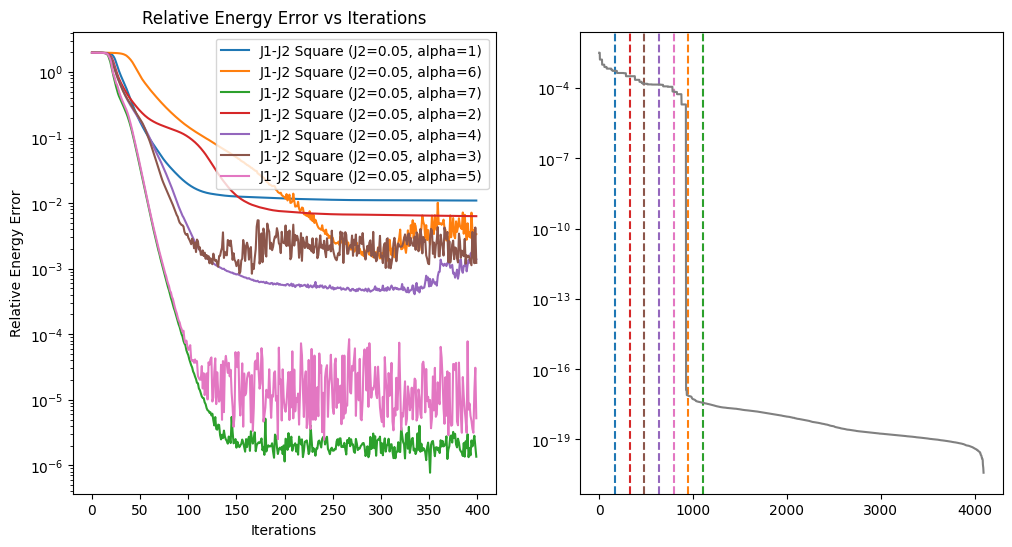

In [7]:
import h5py
import matplotlib.pyplot as plt


h5_files = [os.path.join("../data/tunable_square/", f) for f in os.listdir('../data/tunable_square/') if f.endswith('.h5')]
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2,1)
ax_Ce = fig.add_subplot(1, 2, 2)
# Open the HDF5 file
ed_energy = 0
hilbert = nk.hilbert.Spin(1/2, N=g.n_nodes)
for file in h5_files:
    with h5py.File(file, "r") as f:
        energy = f["en_var_steps"][:]
        e0 = f["exact_ground_energy"][()]
        J2 = f.attrs["J2"]
        alpha = f.attrs["alpha"]
        ed_energy = e0
        model = f.attrs["name"]
        psi = f["psi_0"][:]
        relative_energy_error = (energy - e0) / abs(e0)
        ce_values = np.sort(np.abs(ce.fwht_coeffs_in_cluster_col_order((psi), hilbert)))[::-1]
        # Plot the relative energy error
        p = ax.plot(range(len(relative_energy_error)), relative_energy_error, linestyle='-', label=model+f" (J2={J2}, alpha={alpha})")
        # Plot Nparams vertical line in the same color as the current plot
        ax_Ce.axvline(Nparams(alpha, g.n_nodes), color=p[0].get_color(), linestyle='--', label=f'Nparams (alpha={alpha})')
ax_Ce.plot(range(len(ce_values)), ce_values, linestyle='-', label=model+f" (J2={J2}, alpha={alpha})",color ='gray')
ax.set_yscale('log')
ax_Ce.set_yscale('log')
ax.set_xlabel("Iterations")
ax.set_ylabel("Relative Energy Error")
ax.set_title("Relative Energy Error vs Iterations")
ax.legend()
        # ax.grid(True)
plt.show()

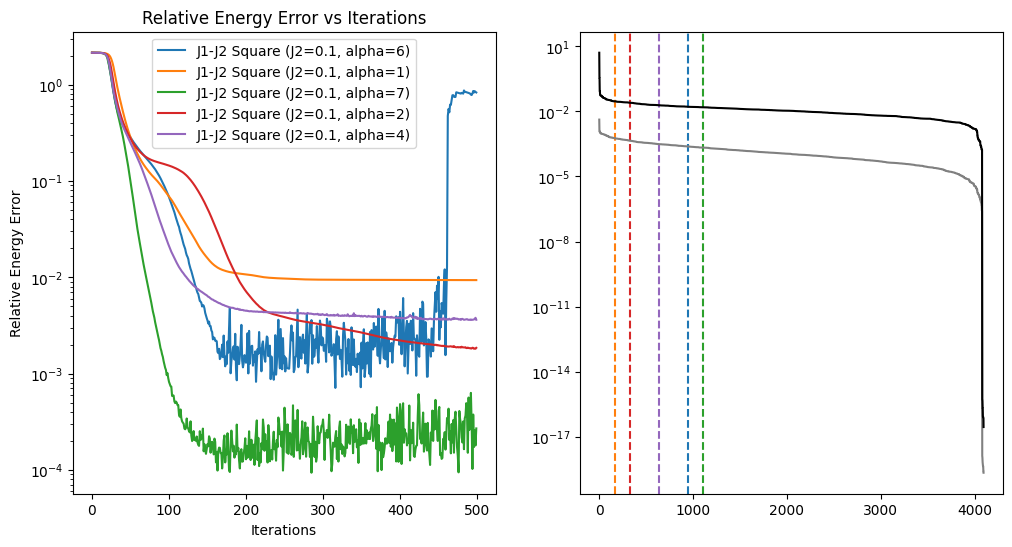

In [8]:
import h5py
import matplotlib.pyplot as plt


h5_files = [os.path.join("../data/tunable_square_constraint/", f) for f in os.listdir('../data/tunable_square_constraint/') if f.endswith('.h5')]
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2,1)
ax_Ce = fig.add_subplot(1, 2, 2)
# Open the HDF5 file
ed_energy = 0
hilbert = nk.hilbert.Spin(1/2, N=g.n_nodes)
for file in h5_files:
    with h5py.File(file, "r") as f:
        energy = f["en_var_steps"][:]
        e0 = f["exact_ground_energy"][()]
        J2 = f.attrs["J2"]
        alpha = f.attrs["alpha"]
        ed_energy = e0
        model = f.attrs["name"]
        psi = f["psi_0"][:]
        relative_energy_error = (energy - e0) / abs(e0)
        ce_values = np.sort(np.abs(ce.fwht_coeffs_in_cluster_col_order((psi), hilbert)))[::-1]
        p = ax.plot(range(len(relative_energy_error)), relative_energy_error, linestyle='-', label=model+f" (J2={J2}, alpha={alpha})")
        cume_values = np.sort(np.abs(ce.fwht_coeffs_in_cluster_col_order(np.log(psi), hilbert)))[::-1]
        # Plot Nparams vertical line in the same color as the current plot
        ax_Ce.axvline(Nparams(alpha, g.n_nodes), color=p[0].get_color(), linestyle='--', label=f'Nparams (alpha={alpha})')
ax_Ce.plot(range(len(ce_values)), ce_values, linestyle='-', label=model+f" (J2={J2}, alpha={alpha})",color ='gray')
ax_Ce.plot(range(len(cume_values)), cume_values, linestyle='-', label=model+f" (J2={J2}, alpha={alpha})",color ='black')
ax.set_yscale('log')
ax_Ce.set_yscale('log')
ax.set_xlabel("Iterations")
ax.set_ylabel("Relative Energy Error")
ax.set_title("Relative Energy Error vs Iterations")
ax.legend()
        # ax.grid(True)
plt.show()

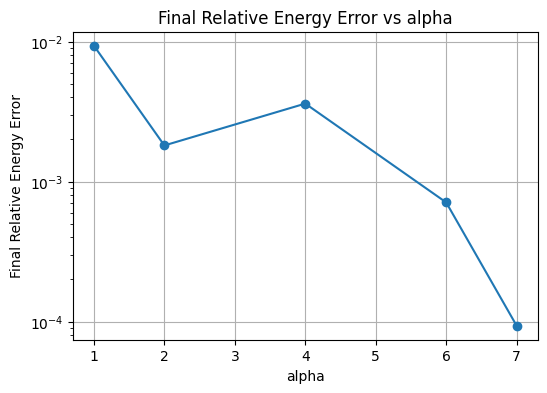

In [9]:
import h5py

import matplotlib.pyplot as plt

alpha_energy_errors = {}

for file in h5_files:
    with h5py.File(file, "r") as f:
        energy = f["en_var_steps"][:]
        e0 = f["exact_ground_energy"][()]
        alpha_val = f.attrs["alpha"]
        # e_var = np.mean(energy[-100:-1])
        e_var = np.min(energy)
        rel_error = (e_var - e0) / abs(e0)
        alpha_energy_errors[alpha_val] = rel_error

alphas = sorted(alpha_energy_errors.keys())
errors = [alpha_energy_errors[a] for a in alphas]

plt.figure(figsize=(6,4))
plt.plot(alphas, errors, marker='o')
plt.xlabel("alpha")
plt.ylabel("Final Relative Energy Error")
plt.yscale('log')
plt.title("Final Relative Energy Error vs alpha")
plt.grid(True)
plt.show()

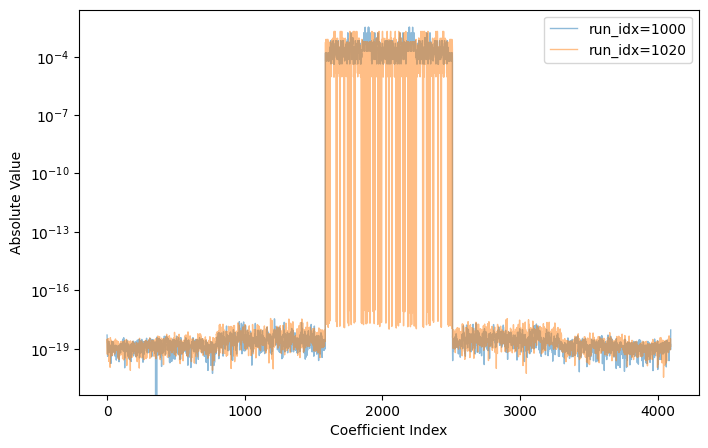

In [10]:
def plot_cluster_expansion(H, hilbert, ax=None, label=None,sort = False,log_psi = False):
    """
    Plots the cluster expansion coefficients of the ground state for a given Hamiltonian.

    Parameters:
        H: NetKet Hamiltonian operator
        hilbert: NetKet Hilbert space
        ax: matplotlib axis to plot on (optional)
        label: label for the plot (optional)
    """
    # Compute ground state using exact diagonalization
    en,psi_gs = nk.exact.lanczos_ed(H, k=1, compute_eigenvectors=True)
    if log_psi:
        psi_gs = np.log(psi_gs)
    ce_values = np.abs(ce.fwht_coeffs_in_cluster_col_order(psi_gs, hilbert))
    if sort:
        ce_values = np.sort(ce_values)[::-1]
    # ce_values = np.sort(np.abs(ce_module.fwht_coeffs_in_cluster_col_order(psi_gs, hilbert)))[::-1]

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(range(len(ce_values)), ce_values, label=label or "Cluster Expansion")
    ax.set_yscale('log')
    ax.set_xlabel("Coefficient Index")
    ax.set_ylabel("Absolute Value")
    ax.set_title("Cluster Expansion of Ground State")
    if label:
        ax.legend()
    plt.show()


def plot_cluster_expansion_range(run_idx_range, sort=False):
    """
    Plots the cluster expansion coefficients for a range of run_idx values.

    Parameters:
        run_idx_range: iterable of run_idx values
    """
    fig, ax = plt.subplots(figsize=(8,5))
    for idx in run_idx_range:
        g, hi, H = thm.get_J1J2_Hamiltonian(idx)
        en, psi_gs = nk.exact.lanczos_ed(H, k=1, compute_eigenvectors=True)
        ce_values = np.abs(ce.fwht_coeffs_in_cluster_col_order(psi_gs, hi))
        if sort:
            ce_values = np.sort(ce_values)[::-1]
        ax.plot(range(len(ce_values)), ce_values, label=f"run_idx={idx}",alpha=0.5,lw=1)
    ax.set_yscale('log')
    ax.set_xlabel("Coefficient Index")
    ax.set_ylabel("Absolute Value")
    ax.legend()
    plt.show()

# g, hi, H = thm.get_J1J2_Hamiltonian(run_idx)
plot_cluster_expansion_range(range(1000,1021,20),sort=False)
# plot_cluster_expansion(H, hi, ce, label="Ground State CE")

In [11]:

g, hi, H = thm.get_J1J2_Hamiltonian(10,3,4)
en, psi_gs = nk.exact.lanczos_ed(H, k=1, compute_eigenvectors=True)
ce_values = ce.fwht_coeffs_in_cluster_col_order((psi_gs), hi)
ce_values_abs = np.abs(ce_values)
ce_values_abs_sort = np.sort(ce_values_abs)[::-1]

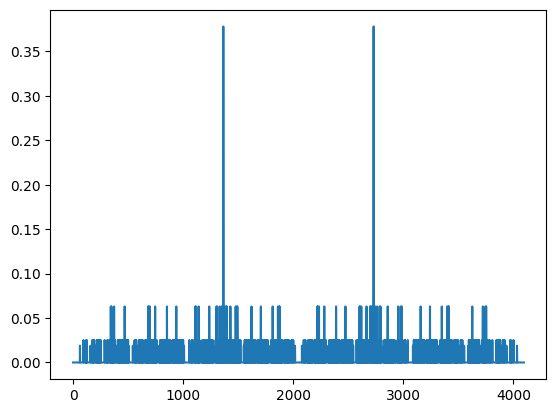

In [12]:
plt.plot(np.abs(psi_gs))

In [13]:
from scipy.stats import unitary_group

def random_one_qubit_unitary():
    """Haar-random U(2)"""
    return unitary_group.rvs(2)

def random_two_qubit_unitary():
    """Haar-random U(2)"""
    return unitary_group.rvs(4)

def constructUnitary(op_list):
    result = op_list[0]
    for op in op_list[1:]:
        result = np.kron(result, op)
    return result
Had = 1/np.sqrt(2) * np.array([[1, 1], [1, -1]])


In [14]:
random_one_qubit_unitary()

array([[-0.41462483+0.90365662j, -0.01306225+0.10639704j],
       [-0.0926677 +0.05388553j,  0.66752062-0.73683463j]])

In [40]:
def psi_guess(x):
    return np.sum(np.exp(x)+1)

psi_vec = np.array([psi_guess(x) for x in hilbert.states()])

In [41]:
aa = [psix / psivs for psix, psivs in zip(psi_gs,psi_vec)]

psi_cp = psi_gs.copy()
psi_cp[:] = aa[:]

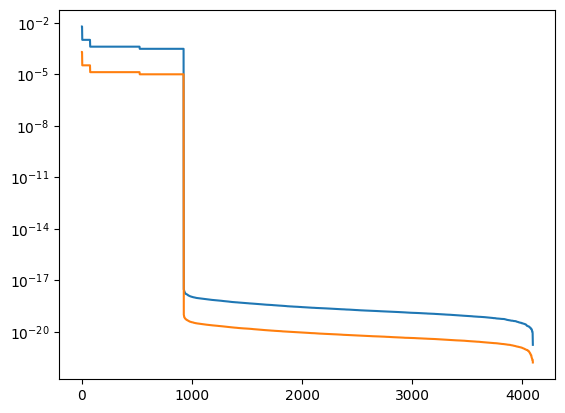

In [42]:
U_site_0 = constructUnitary([random_one_qubit_unitary() for _ in range(12)])

ce_values_ref = np.abs(ce.fwht_coeffs_in_cluster_col_order(psi_gs, hi))
ce_values_ref_sort = np.sort(ce_values_ref)[::-1]
plt.plot(ce_values_ref_sort)

ce_values = ce.fwht_coeffs_in_cluster_col_order(psi_cp, hi)
ce_values_abs = np.abs(ce_values)
ce_values_abs_sort = np.sort(ce_values_abs)[::-1]

plt.plot(ce_values_abs_sort)
plt.yscale('log')
# plt.xlim(0,1500)

In [16]:
np.sum(np.abs(psi_gs)>1e-6)

np.int64(924)

In [17]:
np.sum(ce_values_abs > 1e-6)

np.int64(4096)

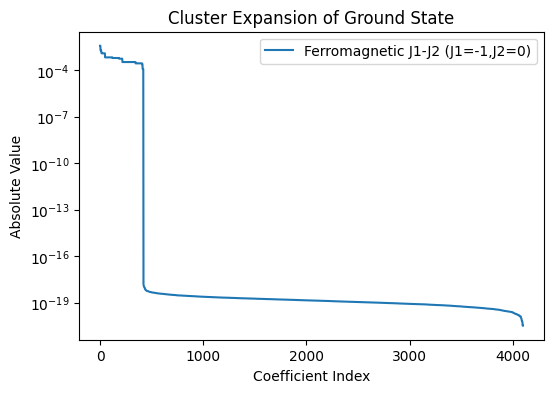

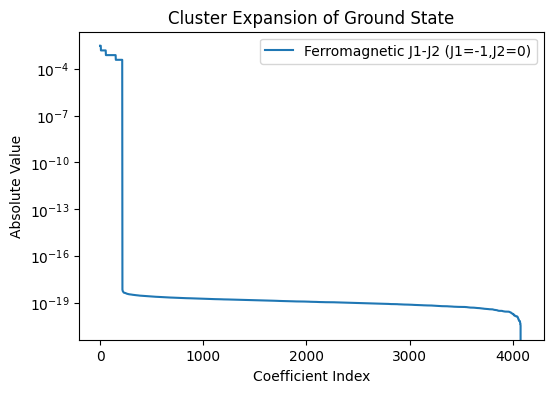

In [18]:
g, hi, H = thm.get_J1J2kagome_Hamiltonian(1.0, 1., 2, 2)
# g, hi, H = thm.get_J1J2Square_Hamiltonian(1.0, .12, 4, 3)
plot_cluster_expansion(H, hi,  label="Ferromagnetic J1-J2 (J1=-1,J2=0)",sort=True)
plt.show()
g, hi, H = thm.get_J1J2kagome_Hamiltonian(1.0, 0.0, 2, 2)
# g, hi, H = thm.get_J1J2Square_Hamiltonian(1.0, .12, 4, 3)
plot_cluster_expansion(H, hi,  label="Ferromagnetic J1-J2 (J1=-1,J2=0)",sort=True)
plt.show()

In [19]:

g, hi, H = get_J1J2Square_Hamiltonian(1.0, .13, 4, 4)

plot_cluster_expansion(H, hi,  label="Ferromagnetic J1-J2 (J1=-1,J2=0)")

NameError: name 'get_J1J2Square_Hamiltonian' is not defined

32


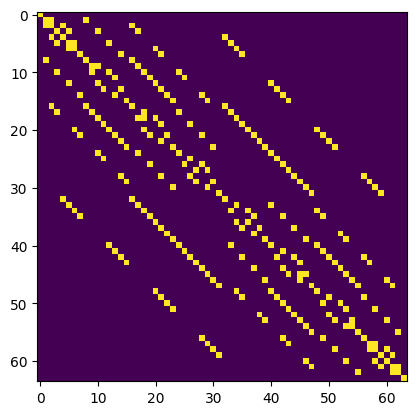

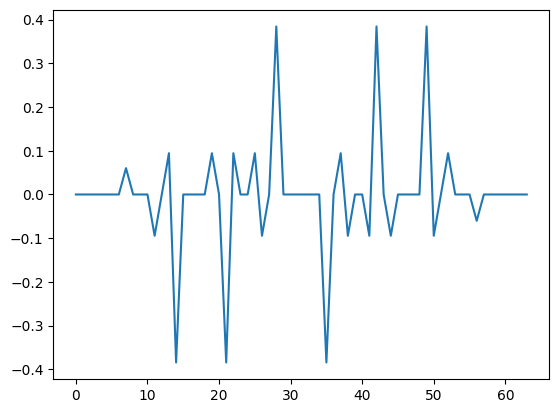

In [ ]:
H.to_dense()

Array([[9. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 3. , 0.5, ..., 0. , 0. , 0. ],
       [0. , 0.5, 3. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 3. , 0.5, 0. ],
       [0. , 0. , 0. , ..., 0.5, 3. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 9. ]], dtype=float64)

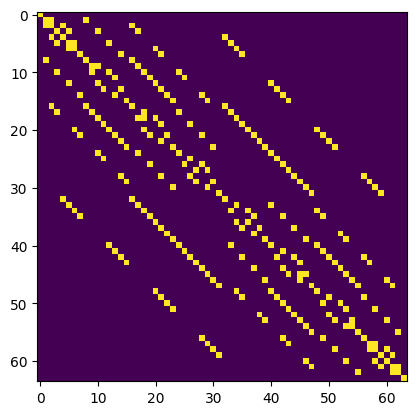